In [4]:
import pandas as pd
import numpy as np


In [5]:
# load data
df = pd.read_csv('combined_data.csv')
df

title source  title_length
0       Iranian President Raisi is killed in helicopte...    nbc             8
1       Kristen Cavallari and Jay Cutler to divorce af...    nbc            11
2       Why Atlanta spa shooters Asian acquaintances c...    nbc            14
3                  The best TV streaming services in 2024    nbc             7
4       Mike Johnson wont commit to bringing House bac...    nbc            15
...                                                   ...    ...           ...
353917                 Statins not linked to suicide risk    nbc             6
353918                 Mono may increase risk of Hodgkins    nbc             6
353919             Herpes virus tied to rare lung disease    nbc             7
353920                Scan reveals hidden life of fetuses    nbc             6
353921                   Camp helps kids with cancer live    nbc             6

[353922 rows x 3 columns]

In [6]:
# check the source balance
df['source'].value_counts()


source
foxnews    233726
nbc        120196
Name: count, dtype: int64

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import pandas as pd

# Enable tqdm to show progress for Pandas operations
tqdm.pandas()

# Assuming data is already loaded into df
X = df['title']
y = df['source']

# Step 1: Split the data
print("Splitting the data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Vectorize the text using TF-IDF
print("Vectorizing text using TF-IDF...")
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(tqdm(X_train, desc="Fitting TF-IDF on train set"))
X_test = vectorizer.transform(tqdm(X_test, desc="Transforming TF-IDF on test set"))

# Step 3: Encode the target labels
print("Encoding target labels...")
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)


Splitting the data...
Vectorizing text using TF-IDF...


Transforming TF-IDF on test set: 100%|██████████| 70785/70785 [00:00<00:00, 255003.82it/s]


Encoding target labels...


In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((283137, 69008), (283137,), (70785, 69008), (70785,))

In [13]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# Initialize Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
}

# Train and Evaluate Models
results = []

for model_name, model in tqdm(models.items(), desc="Training and Evaluating Models"):
    print(f"\n=== {model_name} ===")
    
    # Training
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    
    # Evaluation
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("Classification Report:\n", report)
    print("Accuracy:", accuracy)
    
    results.append({
        "Model": model_name,
        "Classification Report": report,
        "Accuracy": accuracy
    })





Training and Evaluating Models:   0%|          | 0/3 [00:00<?, ?it/s]


=== Logistic Regression ===

Training Logistic Regression...


Training and Evaluating Models:  33%|███▎      | 1/3 [00:01<00:03,  1.90s/it]


Evaluating Logistic Regression...
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86     46733
           1       0.76      0.62      0.68     24052

    accuracy                           0.80     70785
   macro avg       0.79      0.76      0.77     70785
weighted avg       0.80      0.80      0.80     70785

Accuracy: 0.8032775305502579

=== Random Forest ===

Training Random Forest...

Evaluating Random Forest...


Training and Evaluating Models:  67%|██████▋   | 2/3 [07:46<04:34, 274.03s/it]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85     46733
           1       0.79      0.50      0.61     24052

    accuracy                           0.79     70785
   macro avg       0.79      0.72      0.73     70785
weighted avg       0.79      0.79      0.77     70785

Accuracy: 0.7864236773327682

=== XGBoost ===

Training XGBoost...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:53:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Training and Evaluating Models: 100%|██████████| 3/3 [08:00<00:00, 160.05s/it]


Evaluating XGBoost...
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83     46733
           1       0.77      0.35      0.48     24052

    accuracy                           0.74     70785
   macro avg       0.75      0.65      0.65     70785
weighted avg       0.75      0.74      0.71     70785

Accuracy: 0.7416966871512326


In [15]:
# Initialize results summary
results_summary = []

from sklearn.model_selection import GridSearchCV

# Define parameter grids for the models
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# Train and evaluate models
for model_name, model in models.items():
    print(model_name)
    # Perform Grid Search for sklearn or XGBoost model
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        
    # Predict with the best model
    y_pred = best_model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    results_summary.append({'model': model_name, 'accuracy': accuracy, 'best_params': grid_search.best_params_})
    print(accuracy)
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Convert results summary to DataFrame
results_df = pd.DataFrame(results_summary)
results_df


Logistic Regression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...............................C=0.01, solver=lbfgs; total time=   0.4s
[CV] END ...............................C=0.01, solver=lbfgs; total time=   0.4s
[CV] END ...............................C=0.01, solver=lbfgs; total time=   0.4s
[CV] END ...............................C=0.01, solver=lbfgs; total time=   0.5s
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.4s
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.4s
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.4s
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.4s
[CV] END ...............................C=0.01, solver=lbfgs; total time=   0.5s
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.5s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.9s
[CV] END ...................

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=12.6min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=12.5min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=12.8min
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=13.0min
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=10.9min
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=11.3min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=24.9min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=25.1min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=25.8min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=26.0min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=26.3min
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=11.1min
[CV] END ma

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   9.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   9.1s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   9.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   9.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   9.2s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  16.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  16.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  16.7s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  16.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  16.8s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  20.1s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  20.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  31.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  31.5s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  20.3s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  20.6s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  20.9s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  31.8s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  32.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=  32.1s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:22:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  39.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  39.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:23:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  39.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  39.8s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:23:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  39.5s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:23:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  46.1s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:23:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  47.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:23:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  47.0s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:23:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  48.8s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:23:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time= 1.3min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:23:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time= 1.3min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time= 1.3min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:24:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time= 1.3min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:24:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:24:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time= 1.3min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:24:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  53.9s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:24:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   9.9s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:24:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   9.5s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:24:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   9.7s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:24:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   9.7s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:24:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   9.7s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:24:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  18.1s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:24:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  17.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:24:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  17.8s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:25:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  18.1s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:25:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 1.9min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  18.9s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:25:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 1.9min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:25:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 2.3min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:25:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  33.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:25:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  33.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:25:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  31.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:25:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 2.4min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:25:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  31.1s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=  18.7s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=  18.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  31.2s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=  18.8s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=  18.7s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 2.4min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=5, n_estimators=50; total time=  19.0s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  34.0s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  34.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  34.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  33.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  33.7s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:26:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time= 1.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  37.7s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time= 1.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  38.2s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 3.7min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 3.7min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 3.7min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 3.7min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 3.7min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time= 1.1min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time= 1.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time= 1.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  57.9s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time= 1.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time= 1.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=3, n_estimators=50; total time=   9.7s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=3, n_estimators=50; total time=   9.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=3, n_estimators=50; total time=   9.2s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=3, n_estimators=50; total time=   9.1s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=3, n_estimators=50; total time=   8.9s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 1.6min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 1.5min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=  17.0s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=  16.5s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 1.6min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=  15.9s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=  15.9s
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 1.6min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 1.6min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=  15.7s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time=  17.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=  29.8s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time=  17.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=  29.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=  29.6s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=  29.4s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=  29.5s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time=  17.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time=  17.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=5, n_estimators=50; total time=  18.0s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:29:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time= 2.5min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time= 2.5min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time= 2.5min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time= 2.5min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=  33.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=  33.1s
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=  33.1s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=  34.0s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time= 2.1min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=  34.1s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=7, n_estimators=50; total time=  35.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=7, n_estimators=50; total time=  36.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=7, n_estimators=50; total time=  35.0s
[CV] END ....learning_rate=0.2, max_depth=7, n_estimators=50; total time=  35.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ....learning_rate=0.2, max_depth=7, n_estimators=50; total time=  36.2s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:30:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time= 1.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time= 1.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time= 1.1min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time= 1.1min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=200; total time= 1.1min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time= 1.1min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time= 1.1min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time= 1.0min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=  59.2s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=  59.9s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time= 1.6min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time= 1.6min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time= 1.6min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time= 1.6min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=200; total time= 1.5min


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:32:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
0.7528854983400438
              precision    recall  f1-score   support

     foxnews       0.75      0.94      0.83     46733
         nbc       0.77      0.39      0.51     24052

    accuracy                           0.75     70785
   macro avg       0.76      0.66      0.67     70785
weighted avg       0.76      0.75      0.73     70785



model  accuracy  \
0  Logistic Regression  0.807982   
1        Random Forest  0.787865   
2              XGBoost  0.752885   

                                         best_params  
0                   {'C': 10, 'solver': 'liblinear'}  
1  {'max_depth': None, 'min_samples_split': 5, 'n...  
2  {'learning_rate': 0.2, 'max_depth': 7, 'n_esti...

In [16]:
# show full content of the column
pd.set_option('display.max_colwidth', None)
results_df

model  accuracy  \
0  Logistic Regression  0.807982   
1        Random Forest  0.787865   
2              XGBoost  0.752885   

                                                        best_params  
0                                  {'C': 10, 'solver': 'liblinear'}  
1  {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}  
2       {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:03:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


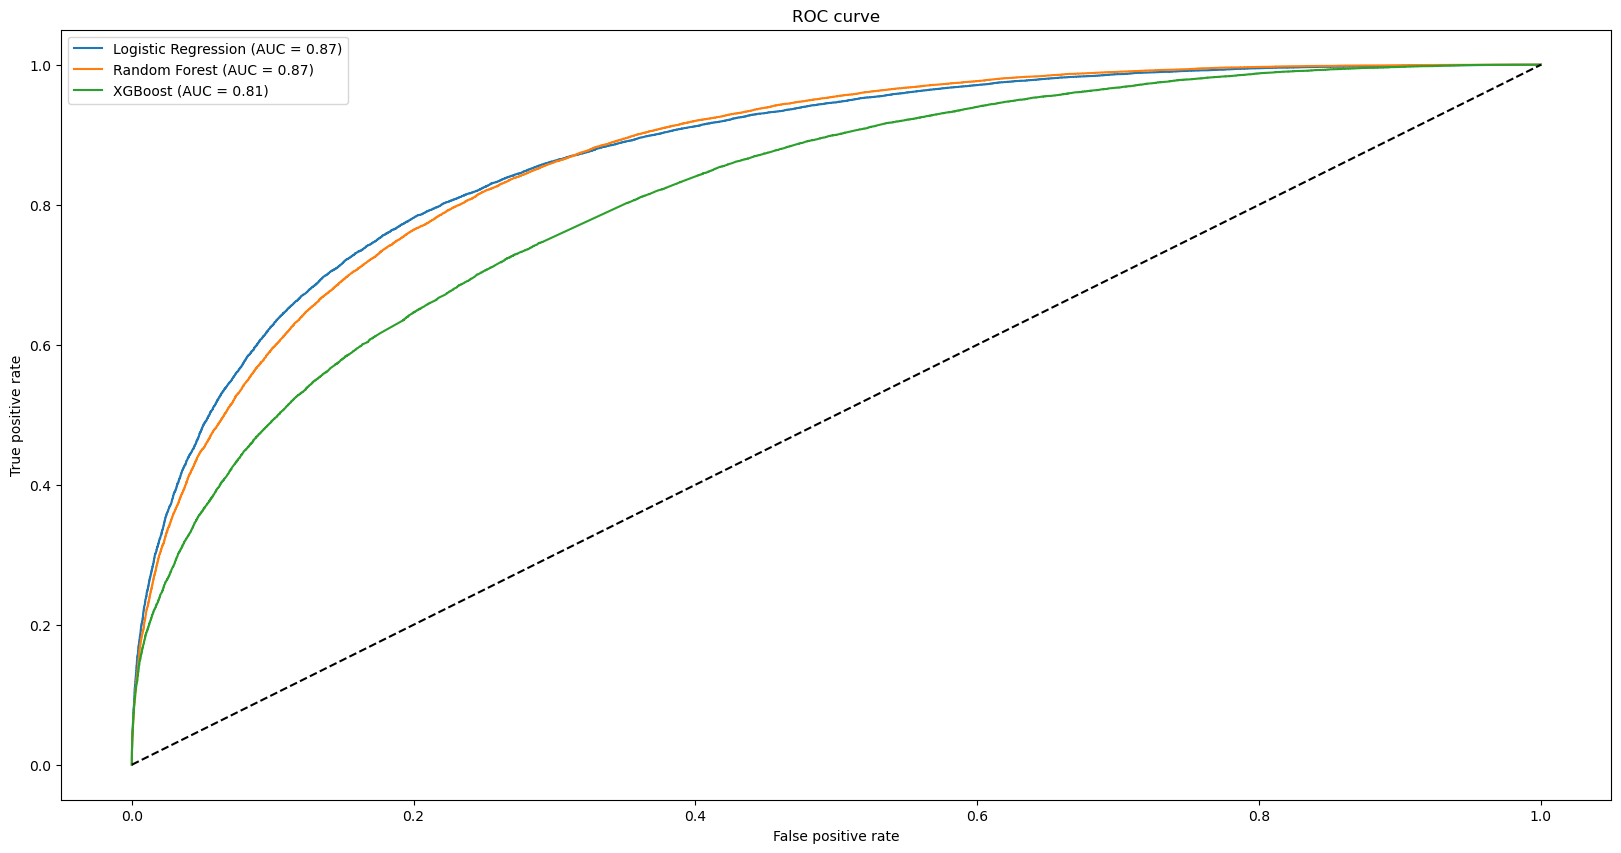

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# plt with size 20,10
plt.figure(figsize=(20, 10))

# Calculate AUC-ROC for each model with best parameters
for model_name, model in models.items():
    best_params = results_df[results_df['model'] == model_name]['best_params'].values[0]
    best_model = models[model_name].set_params(**best_params)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()


In [10]:
# save the model
import joblib

# Save the best model
best_model = models['Random Forest']
best_model.set_params(**results_df[results_df['model'] == 'Random Forest']['best_params'].values[0])
best_model.fit(X_train, y_train)
joblib.dump(best_model, 'best_model.pkl')

# Save the encoder
joblib.dump(encoder, 'encoder.pkl')

# Save the vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')

# Save the results summary
results_df.to_csv('results_summary.csv', index=False)

In [15]:
# deploy the best model
# given the title, predict the source
def predict_source(title):
    # Load the model
    model = joblib.load('best_model.pkl')
    encoder = joblib.load('encoder.pkl')
    vectorizer = joblib.load('vectorizer.pkl')
    
    # Vectorize the input
    X = vectorizer.transform([title])
    
    # Predict
    y_pred = model.predict(X)
    return encoder.inverse_transform(y_pred)[0]

# Test the function
predict_source('Wife of murdered Minnesota pastor hired 3 men to kill husband after affair: police')




'foxnews'